## 多层感知机 Multilayer Perceptron (MLP)

<img src="data/logo.png" alt="Drawing" style="width: 300px;"/>

在这个课程项目中我们将会探索学习最基本的神经网络: 多层感知机。然后用PyTorch实现

**注意**: 这个项目只是用PyTorch实现多层感知机的基础，所以为了保持教程的简洁我们不会介绍过多的机器学习必要步骤(比如划分训练集测试集时的类平衡，验证集，early stopping)。我们会在下节课学到这些最佳实践。

## Overview


<img src="data/mlp.png" alt="Drawing" style="width: 400px;"/>

~$z_2 = XW_1~$

~$a_2 = f(z_2)~$

~$z_3 = a_2W_2~$

~$\hat{y} = softmax(z_3)~$ # 分类

*其中*:
* ~$X~$ = 输入 | ~$\in \mathbb{R}^{NXD}~$ (~$D~$ 特征数量)
* ~$W_1~$ = 第一层的权重 | ~$\in \mathbb{R}^{DXH}~$ (~$H~$ 第一层的隐藏单元数)
* ~$z_2~$ = 第一层网络的输出  ~$\in \mathbb{R}^{NXH}~$
* ~$f~$ = 非线性激活函数
* ~$a_2~$ = 通过激活函数后的第一层输出 | ~$\in \mathbb{R}^{NXH}~$
* ~$W_2~$ = 第二层权重 | ~$\in \mathbb{R}^{HXC}~$ (~$C~$ is 分类类别数)
* ~$\hat{y}~$ = 预测值 | ~$\in \mathbb{R}^{NXC}~$ (~$N~$ 样本个数)

这是一个简单的二层多层感知机

* **目标:** 给定输入 ~$X~$, 预测它属于类别 ~$y~$ 的概率。非线性激活函数的使用后可以帮助训练复杂，非线性的数据。
* **优点:**
	* 在非线性数据上表现非常好
* **缺点:**
	* 容易过拟合
	* 计算复杂度和网络复杂度成正比
	* 可解释性不强
* **其它:** 未来我们会接触的神经网络会使用MLP作为向前传播得模块 (非线性操作后的仿射变换affine transformation(XW))

## 训练

*步骤* :

1. 随机初始化模型权重~$W~$ (我们以后会对更有效的初始化权重策略做介绍)
2. 将输入值~$X~$传入模型进行向前传播，得到结果概率
3. 使用损失函数计算预测值 ~$\hat{y}~$ (比如 [0.3, 0.3, 0.4]) 和实际值 ~$y~$ (比如[0, 0, 1])的差，得到损失值 ~$J~$ 常用的逻辑回归损失函数是交叉熵函数。
  * ~$z_2 = XW_1~$
  * ~$a_2 = max(0, z_2)~$ # 使用ReLU激活函数
  * ~$z_3 = a_2W_2~$
  * ~$\hat{y} = softmax(z_3)~$
  * ~$J(\theta) = - \sum_i y_i ln (\hat{y_i})~$
4. 根据模型权重计算损失梯度 ~$J(\theta)~$
   * ~$\frac{\partial{J}}{\partial{W_{2j}}} = a_2\hat{y}, \frac{\partial{J}}{\partial{W_{2y}}} = a_2(\hat{y}-1)~$
   * ~$\frac{\partial{J}}{\partial{W_1}} = \frac{\partial{J}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{a_2}}  \frac{\partial{a_2}}{\partial{z_2}}  \frac{\partial{z_2}}{\partial{W_1}}  = W_2(\partial{scores})(\partial{ReLU})X~$
   
5. 使用梯度下降做反向传播来更新模型权重。更新后的权重将会使得输出不正确的结果 ~$j~$ 的概率降低, 从而提高输出正确类别 ~$y~$ 的概率
  * ~$W_i = W_i - \alpha\frac{\partial{J}}{\partial{W_i}}~$
6. 重复2 - 4步直到模型的表现最好.

## 数据
先生成一些非线性数据来做分类任务。

In [12]:
# 安装Pytorch
!pip install torch torchvision --upgrade -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Requirement already up-to-date: torch in d:\users\i9233\anaconda3\lib\site-packages (1.0.1)
Requirement already up-to-date: torchvision in d:\users\i9233\anaconda3\lib\site-packages (0.2.2.post3)


In [13]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

In [14]:
# 参数
args = Namespace(
    seed=1234,
    num_samples_per_class=500,
    dimensions=2,
    num_classes=3,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=100,
    learning_rate=1e-0,
    regularization=1e-3,
    num_epochs=200,
)

# 设置随机种子来保证结果可复现
np.random.seed(args.seed)

In [15]:
# 生成非线性数据
def generate_data(num_samples_per_class, dimensions, num_classes):
    # 生成螺旋状数据
    X_original = np.zeros((num_samples_per_class*num_classes, dimensions))
    y = np.zeros(num_samples_per_class*num_classes, dtype='uint8')
    for j in range(num_classes):
        ix = range(num_samples_per_class*j,num_samples_per_class*(j+1))
        r = np.linspace(0.0,1,num_samples_per_class) # radius
        t = np.linspace(j*4,(j+1)*4,num_samples_per_class) + \
        np.random.randn(num_samples_per_class)*0.2 # theta
        X_original[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    X = np.hstack([X_original])

    return X, y

In [16]:
# 生成 X 和 y
X, y = generate_data(num_samples_per_class=args.num_samples_per_class, 
                     dimensions=args.dimensions, num_classes=args.num_classes)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

X: (1500, 2)
y: (1500,)


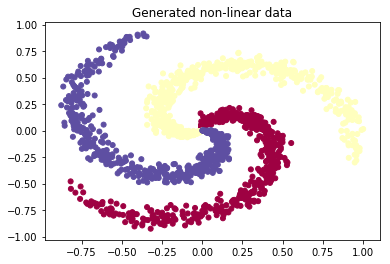

In [17]:
# 可视化
plt.title("Generated non-linear data")
plt.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap=plt.cm.Spectral)
plt.show()

In [18]:
# 转换为PyTorch tensor
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

In [19]:
# 打乱数据
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# 切分训练集测试集
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 1125 train samples and 375 test samples.


## 线性模型

在构建神经网络之前，我们先来看看为什么线性模型在这次生成的数据上表现不会很好。

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [21]:
# 线性模型
class LogisticClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LogisticClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = self.fc1(x_in)
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [22]:
# 初始化模型
model = LogisticClassifier(input_dim=args.dimensions, 
                           hidden_dim=args.num_hidden_units, 
                           output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of LogisticClassifier(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [23]:
# 优化
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) # Adam optimizer (usually better than SGD)

In [24]:
# 准确率
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [25]:
# 训俩
for t in range(args.num_epochs):
    # 向前传播
    y_pred = model(X_train)
    
    # 准确率
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # 损失
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | acc: {2:.1f}%".format(
            t, loss, accuracy))

    # 梯度归零
    optimizer.zero_grad()

    # 反向传播
    loss.backward()

    # 更新权重
    optimizer.step()

epoch: 00 | loss: 1.1234 | acc: 34.1%
epoch: 20 | loss: 13.4347 | acc: 53.3%
epoch: 40 | loss: 4.7009 | acc: 58.2%
epoch: 60 | loss: 1.2234 | acc: 48.2%
epoch: 80 | loss: 0.7776 | acc: 52.9%
epoch: 100 | loss: 0.7405 | acc: 53.6%
epoch: 120 | loss: 0.7352 | acc: 53.5%
epoch: 140 | loss: 0.7348 | acc: 52.8%
epoch: 160 | loss: 0.7347 | acc: 53.0%
epoch: 180 | loss: 0.7347 | acc: 52.8%


In [26]:
# 预测
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [27]:
# 训练集和测试集上的准确率
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 52.8%, test acc: 53.3%


In [28]:
# 可视化
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

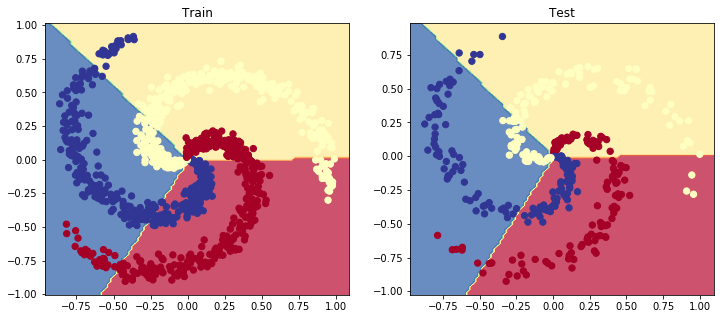

In [29]:
# 可视化决策边界
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

In [30]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
# 画出混淆矩阵
def plot_confusion_matrix(cm, classes):
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

              precision    recall  f1-score   support

           0       0.51      0.60      0.55       119
           1       0.55      0.59      0.57       116
           2       0.55      0.43      0.48       140

   micro avg       0.53      0.53      0.53       375
   macro avg       0.53      0.54      0.53       375
weighted avg       0.54      0.53      0.53       375



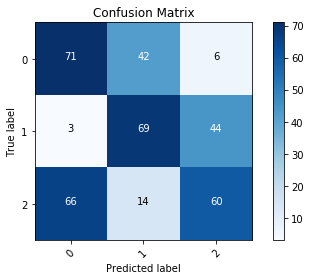

In [32]:
# 混淆矩阵
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

## 非线性模型


现在我们来看看多层感知机的性能。注意这里唯一的区别是我们添加了非线性激活函数(用了ReLU, 它就是简单的 ~$max(0, z))~$)

In [33]:
# MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) # activaton function added!
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [34]:
# 初始化模型
model = MLP(input_dim=args.dimensions, 
            hidden_dim=args.num_hidden_units, 
            output_dim=args.num_classes)
print (model.named_modules)

<bound method Module.named_modules of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


In [35]:
# 优化
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [36]:
# 训练
for t in range(args.num_epochs):
    # 向前传播
    y_pred = model(X_train)
    
    # 准确率
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # 损失
    loss = loss_fn(y_pred, y_train)
    
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | acc: {2:.1f}%".format(
            t, loss, accuracy))

    # 梯度归零
    optimizer.zero_grad()

    # 反向传播
    loss.backward()

    # 更新权重
    optimizer.step()

epoch: 00 | loss: 1.1089 | acc: 32.0%
epoch: 20 | loss: 0.5497 | acc: 73.1%
epoch: 40 | loss: 0.2140 | acc: 91.3%
epoch: 60 | loss: 0.1051 | acc: 96.1%
epoch: 80 | loss: 0.0671 | acc: 97.6%
epoch: 100 | loss: 0.0378 | acc: 99.3%
epoch: 120 | loss: 0.0276 | acc: 99.7%
epoch: 140 | loss: 0.0237 | acc: 99.6%
epoch: 160 | loss: 0.0212 | acc: 99.7%
epoch: 180 | loss: 0.0192 | acc: 99.7%


In [37]:
# 预测
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [38]:
# 训练集和测试集的准确率
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 99.7%, test acc: 99.5%


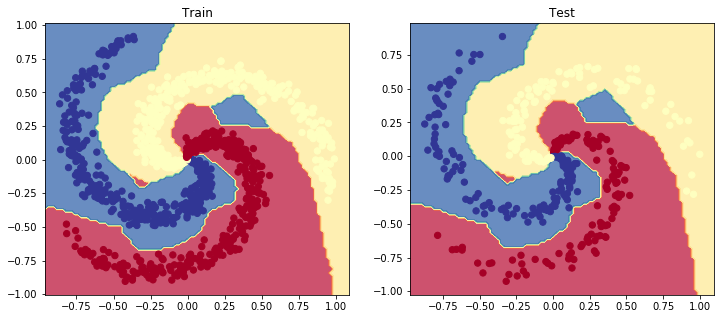

In [39]:
# 可视化决策边界
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       119
           1       1.00      1.00      1.00       116
           2       1.00      0.99      0.99       140

   micro avg       0.99      0.99      0.99       375
   macro avg       0.99      1.00      0.99       375
weighted avg       0.99      0.99      0.99       375



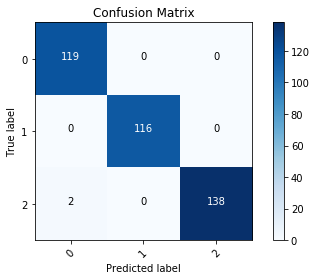

In [40]:
# 混淆矩阵
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

## 可视化权重

到目前为止，我们已经见过了诸如损失，准确率甚至可视化的决策边界。然而模型的权重呢？要对权重做可视化其实有些困难，因为权重是一直在被更新的。
 
但是知道权重的变化情况很关键，因为实际情况下会出现类似，所有权重都接近于0，有些权重值增长过快。这些问题都暗示了当前模型需要进行一些微调或标准化操作，只是我们需要能实际看到权重的值才能发现或者确定问题已经解决。因为权重可能会有很多维度，我们需要做的是可视化这些参数的的平均值和标准差。

需要可视化所有参数时，我们一般使用 [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard)。在K-Lab上使用
Tensorboard 需要一些hack的操作，如果你真的需要使用Tensorbord, 请点击右下角的反馈提交工单，但后续我们会提供更加便捷的tensorboard入口。
但如果你是在本地机器上使用Tensorboard, 你只需要在命令行工具中运行 `tensorboard --logdir='./logs' --port=6006`, 然后在浏览器中打开 `http://localhost:6006`


<img src="data/tensorboard.png" alt="Drawing" style="width: 900px;"/>

下面是一些可以度量和可视化的参数:
1. 损失和准确率
2. 权重的平均数和标准差
3. 激活的均值和标准差
3. 梯度的均值和标准差

In [41]:
# 安装 TensorboardX
!pip3 install tensorboardX

'pip3' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [42]:
# 在端口 6006 上运行 Tensorboard
LOG_DIR = './log'
run_num = 0
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [43]:
get_ipython().system_raw('lt --port 6006 >> data/tensorboard.txt 2>&1 &')


现在我们可以训练模型并且在 tensorboard 上查看可视化结果

In [44]:
# 一些前置工作
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
!pip install Pillow --upgrade -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install image -i https://pypi.tuna.tsinghua.edu.cn/simple
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
    for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

ModuleNotFoundError: No module named 'tensorboardX'

In [45]:
# 初始化 Tensorboard 写入器
run_num += 1
writer = SummaryWriter(log_dir=LOG_DIR+"/run_{}".format(run_num))

NameError: name 'SummaryWriter' is not defined

In [ ]:
# 初始化模型
model = MLP(input_dim=args.dimensions, 
            hidden_dim=args.num_hidden_units, 
            output_dim=args.num_classes)
print (model.named_modules)

In [ ]:
# 优化
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [ ]:
 def write_weights(writer, model, epoch_num):
    for name, param in model.named_parameters():
        
        # 权重
        writer.add_scalar(name+"/mean", param.data.numpy().mean(), epoch_num)
        writer.add_scalar(name+"/std", param.data.numpy().std(), epoch_num)
        
        # 梯度
        writer.add_scalar(name+"/grad_mean", torch.mean(param.grad), epoch_num)
        writer.add_scalar(name+"/grad_std", torch.std(param.grad), epoch_num)
        
        # 权重直方图 (大于1024维会报错)
        if len(param.size()) > 1 and param.size()[-1] <= 1024: 
            writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch_num)

In [ ]:
# 训练
for t in range(args.num_epochs):
    # 向前传播
    y_pred = model(X_train)
    
    # 准确率
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # 损失
    loss = loss_fn(y_pred, y_train)
    
    # 打印checkpoint数据
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy))

    # 梯度归零
    optimizer.zero_grad()

    # 反向传播
    loss.backward()

    # 更新权重
    optimizer.step()
    
    # 写进tensorboard
    writer.add_scalar('metrics/train_loss', loss, t)
    writer.add_scalar('metrics/train_acc', accuracy, t)
    writer.add_scalar('metrics/lr', optimizer.param_groups[0]['lr'], t)
    write_weights(writer=writer, model=model, epoch_num=t)

In [ ]:
print ("Go to this link below to see the Tensorboard:")
!cat tensorboard.txt
print ("Click on SCALARS to see metrics and DISTRIBUTIONS to see weights.")

## 激活函数

在MLP中，我们使用了激活函数 ReLU (~$max(0,z)~$), 它是最广泛使用的激活函数之一。但其实还有别的激活函数可以使用，他们都有各自的特性。


In [ ]:
plt.figure(figsize=(12,3))

# 数据
x = torch.arange(-5., 5., 0.1)

# Sigmoid 函数(将值限定在0到1之间.)
plt.subplot(1, 3, 1)
plt.title("Sigmoid activation")
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.numpy())

# Tanh 函数(将值限定在-1 到 1 之间)
plt.subplot(1, 3, 2)
y = torch.tanh(x)
plt.title("Tanh activation")
plt.plot(x.numpy(), y.numpy())

# Relu 函数(将负值归零处理)
plt.subplot(1, 3, 3)
y = F.relu(x)
plt.title("ReLU activation")
plt.plot(x.numpy(), y.numpy())

# Show plots
plt.show()

## 初始化权重

到现在为止我们都用数值较小的随机数来初始化权重，但其实这种方法并不能提供最优的训练收敛速度。我们的目标是得到可以在所有神经元上获得相似输出分布的权重。一般可以在进行非线性操作前先强制让权重都拥有相同的单位方差。

一个常用的方法是使用 [Xavier初始化方法 (xacier initialization)](https://blog.csdn.net/lanchunhui/article/details/70318941)。

你可能会有这样的疑问，为什么我们不在每次向前传播时都做这个操作呢? 这是个非常好的问题。我们会在以后的课程项目中介绍更多更高阶的方法(比如batch/layer normalization)。

In [ ]:
# MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu')) 

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) # activaton function added!
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

## 过拟合

虽然神经网络在非线性数据上的表现非常好，但同时它也非常容易在训练数据上过拟合，导致在测试集上泛化效果很差。看看下面这个例子就懂了，我们生成了完全随机的数据来拟合有 [~$2*N*C + D~$](https://arxiv.org/abs/1611.03530) 个隐藏神经元的模型。训练效果非常拔群，但是在测试集上的性能表现非常差。我们会在以后的课程中教大家如何应对过拟合的问题。

In [ ]:
# 参数
args = Namespace(
    seed=1234,
    num_samples_per_class=40,
    dimensions=2,
    num_classes=3,
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=2*40*3+2 , # 2*N*C + D
    learning_rate=1e-3,
    regularization=1e-3,
    num_epochs=1000,
)

# 设置可复现的随机种子
np.random.seed(args.seed)

In [ ]:
# 生成随机数据
X = torch.randn(args.num_samples_per_class*args.num_classes, args.dimensions).float()
y = torch.LongTensor([[i]*args.num_samples_per_class 
                       for i in range(args.num_classes)]).view(-1)
print ("X: {0}".format(np.shape(X)))
print ("y: {0}".format(np.shape(y)))

In [ ]:
# 打乱数据
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# 切分数据集
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

In [ ]:
# MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        print 
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) 
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [ ]:
# 初始化模型
model = MLP(input_dim=args.dimensions, hidden_dim=args.num_hidden_units, 
            output_dim=args.num_classes)
print (model.named_modules)

In [ ]:
# 优化
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

In [ ]:
# 训练
for t in range(args.num_epochs):
    # 向前传播
    y_pred = model(X_train)

    # 准确率
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # 损失
    loss = loss_fn(y_pred, y_train)
    
    # 打印checkpoint
    if t%100==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy))

    # 梯度归零
    optimizer.zero_grad()

    # 反向传播
    loss.backward()

    # 更新权重
    optimizer.step()

In [ ]:
# 预测
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [ ]:
# 训练和测试数据的准确率
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

In [ ]:
# 可视化决策边界
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

In [ ]:
# 混淆矩阵
cm = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm=cm, classes=[0, 1, 2])
print (classification_report(y_test, pred_test))

## Dropout

解决过拟合的一个非常好的方法是增加数据的数量，不过这个方法并不一直可行。幸运的是我们还有正则化和添加 dropout 等策略来增加模型的鲁棒性。我们已经学到了正则化操作而且，它可以被非常方便地加入到优化器部分的代码中。

Dropout 是(只在训练过程中)将一些神经元的输出归零的技巧。我们将它应用在每层总数 p% 的神经元，并在每个训练批次更改 p 值。Dropout 防止神经元过于依赖训练数据，并且只是作为一种采样方法，毕竟每次会删掉不同的神经元。


<img src="data/dropout.png" alt="Drawing" style="width: 600px;"/>


In [ ]:
# 参数
args.dropout_p = 0.1 # 40% of the neurons are dropped each pass
args.lambda_l2 = 1e-4 # L2 regularization

In [ ]:
# MLP·
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p) # Defining the dropout
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def init_weights(self):
        init.xavier_normal(self.fc1.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x_in, apply_softmax=False):
        z = F.relu(self.fc1(x_in))
        z = self.dropout(z) # dropping neurons
        y_pred = self.fc2(z)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [ ]:
# 初始化模型
model = MLP(input_dim=args.dimensions, 
            hidden_dim=args.num_hidden_units, 
            output_dim=args.num_classes, 
            dropout_p=args.dropout_p)
print (model.named_modules)

# 优化
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, 
                       weight_decay=args.lambda_l2) # Adding L2 regularization

# 训练
pass

## 其他信息

想了解MLP，激活函数等更详细的知识，可以查看 [这个项目](https://www.kesci.com/home/project/5a4f33596fe91734062efc4c)。